In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.models.signature import infer_signature
import optuna
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    log_loss, f1_score, precision_score, recall_score, make_scorer,
    accuracy_score, confusion_matrix, classification_report
)

/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/customer_churn_0.csv')

In [3]:
df.dtypes

Call  Failure                int64
Complains                    int64
Subscription  Length         int64
Charge  Amount               int64
Seconds of Use               int64
Frequency of use             int64
Frequency of SMS             int64
Distinct Called Numbers      int64
Age Group                    int64
Tariff Plan                  int64
Status                       int64
Age                          int64
Customer Value             float64
Churn                        int64
dtype: object

In [4]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
df.shape

(1050, 14)

In [6]:
df.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

In [7]:
df.duplicated().sum()

np.int64(87)

In [8]:
def plot_numerical_variables(df, drop_columns=None):
    numerical_cols = df.select_dtypes(include=['float', 'int']).columns

    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    for idx, col in enumerate(numerical_cols):
        sns.histplot(data=df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].tick_params(axis='x', rotation=45)
    # Hide any unused subplots
    for ax in axes[len(numerical_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

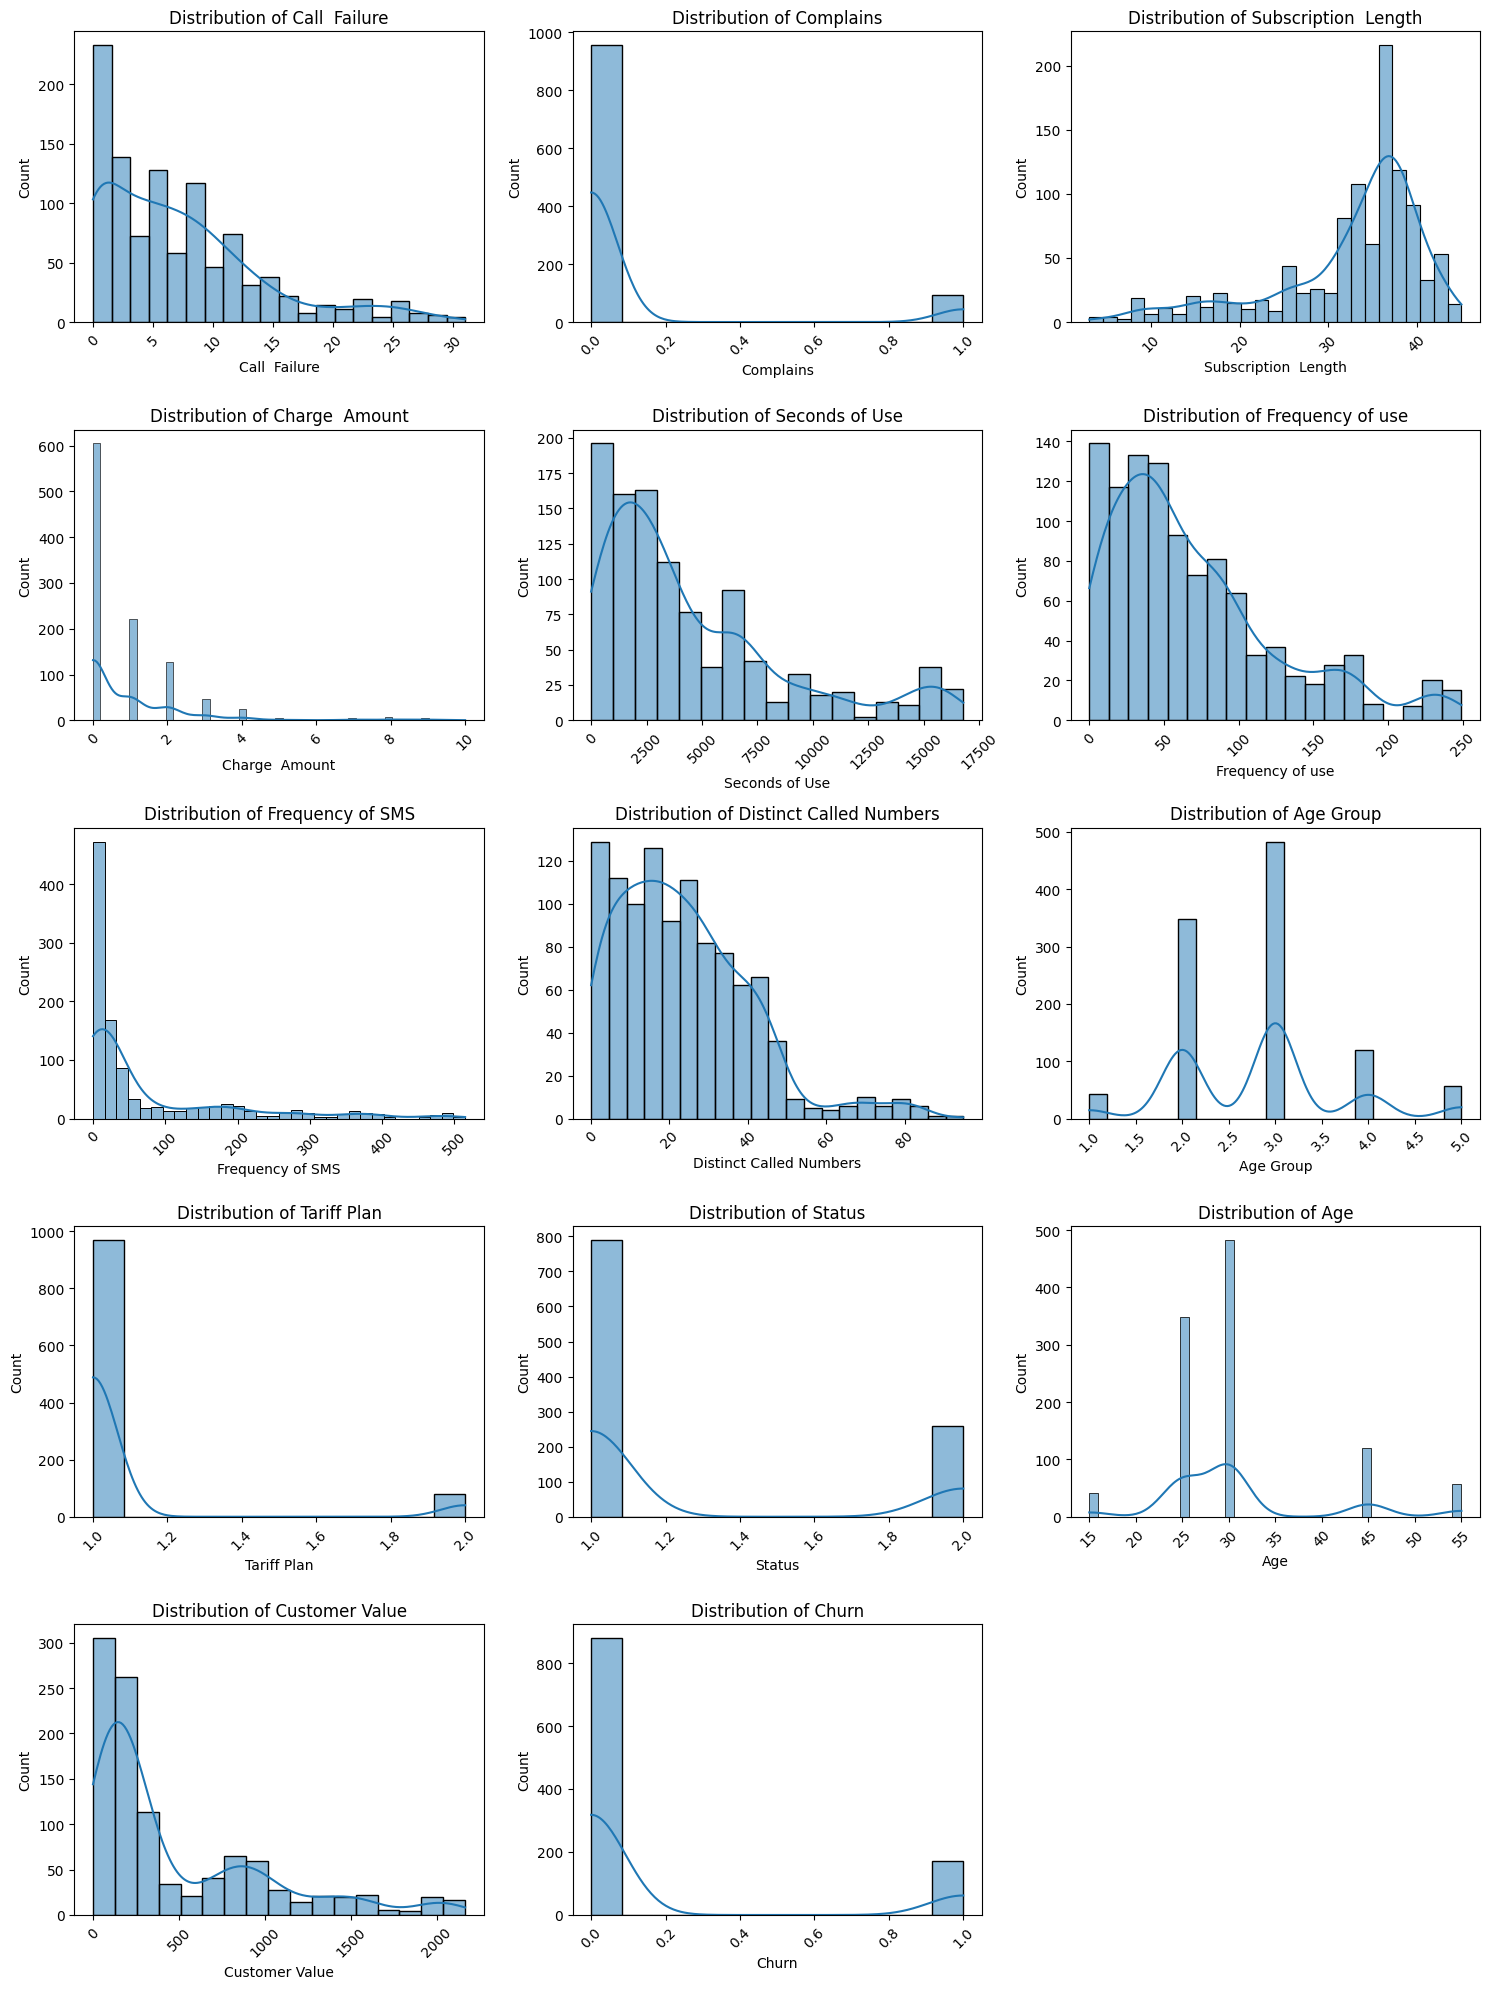

In [9]:
plot_numerical_variables(df)

In [10]:
mlflow.set_tracking_uri("http://18.224.82.30:5000/")
mlflow.set_experiment("mlops-churn-pipeline")

<Experiment: artifact_location='s3://mlops-churn-pipeline/mlflow/1', creation_time=1752288420889, experiment_id='1', last_update_time=1752288420889, lifecycle_stage='active', name='mlops-churn-pipeline', tags={}>

In [11]:
def prepare_data(df):
    X = df.copy()
    y = X.pop('Churn')
    
    X = X.drop(columns=['Age', 'Tariff Plan'])

    return X, y

In [12]:
X, y = prepare_data(df)

In [13]:
X.shape, y.shape

((1050, 11), (1050,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((840, 11), (210, 11), (840,), (210,))

In [ ]:
def train_model(X, y):
    params = {
        "n_estimators": 100,
        "max_depth": 3,
        "learning_rate": 0.1,
        "random_state": 42
    }

    """
    Optuna Best Hyperparameters:
        n_estimators: 266
        learning_rate: 0.06822549561510526
        max_depth: 5
        min_child_weight: 1
        gamma: 0.1433683439383787
        subsample: 0.9115495939943787
        colsample_bytree: 0.8433564143217643
        reg_alpha: 0.7273860161278461
        reg_lambda: 6.805202747140502
    """

    clf = XGBClassifier(**params, objective='binary:logistic', eval_metric='logloss')
    clf.fit(X, y)
    return clf

In [17]:
clf = train_model(X_train, y_train)

In [18]:
def evaluate_model(model, X, y, dataset_name):
    with mlflow.start_run():
        mlflow.set_tag("dataset", dataset_name)

        print("Training model with the following features:")
        for idx, col in enumerate(X.columns):
            print(f"- Feature {idx}: {col}")
            mlflow.log_param(f"feature_{idx}", col)

        mlflow.log_params(model.get_xgb_params())

        y_pred = model.predict(X) # Predict on training data to eval bias first
        y_pred_proba = model.predict_proba(X)

        logloss = log_loss(y, y_pred_proba)
        f1 = f1_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        accuracy = accuracy_score(y, y_pred)

        print(f"\nMetrics for {dataset_name}:")
        print(f"log_loss: {logloss:.4f}")
        print(f"f1_score: {f1:.4f}")
        print(f"precision_score: {precision:.4f}")
        print(f"recall_score: {recall:.4f}")
        print(f"accuracy_score: {accuracy:.4f}")

        mlflow.log_metric("log_loss", logloss)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision_score", precision)
        mlflow.log_metric("recall_score", recall)
        mlflow.log_metric("accuracy_score", accuracy)
        
        print(f"\nClassification Report ({dataset_name}):")
        print(classification_report(y, y_pred))

        cm = confusion_matrix(y, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix ({dataset_name})')
        plt.show()

        # Plot SHAP Summary
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)
        shap.summary_plot(shap_values, X, plot_type="dot", show=False)
        plt.title(f'SHAP Summary Plot ({dataset_name})')
        plt.tight_layout()
        plt.savefig(f'shap_summary_plot_{dataset_name}.png')
        mlflow.log_artifact(f'shap_summary_plot_{dataset_name}.png')
        plt.show()

        model_signature = infer_signature(X, y_pred)
        mlflow.xgboost.log_model(model, artifact_path="model",
            registered_model_name="XGBoostChurnModel",
            signature=model_signature,
            input_example=X.head(1))


In [ ]:
def tune_model_with_cv(X, y):

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 7),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
            "gamma": trial.suggest_float("gamma", 0, 0.5),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 20.0),
            "tree_method": "hist",
            "eval_metric": "logloss"
        }

        model = XGBClassifier(**params)

        # Use stratified CV and recall scoring
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, scoring=make_scorer(recall_score), cv=cv, n_jobs=-1)

        return np.mean(scores)

    # Run the optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("\nBest hyperparameters found:")
    for key, value in study.best_params.items():
        print(f"{key}: {value}")
        
    # Train final model with best hyperparameters on full dataset
    clf = XGBClassifier(**study.best_params, objective='binary:logistic', eval_metric='logloss')
    clf.fit(X, y)

    return clf

In [20]:
clf = tune_model_with_cv(X_train, y_train)

[I 2025-07-12 00:52:12,369] A new study created in memory with name: no-name-cf1a23fb-ab5d-4ead-95bd-f96838c90720
[I 2025-07-12 00:52:14,621] Trial 0 finished with value: 0.6124031007751938 and parameters: {'n_estimators': 382, 'learning_rate': 0.04662259631004589, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.18051647763156586, 'subsample': 0.8360511731520298, 'colsample_bytree': 0.7287293682557222, 'reg_alpha': 0.7260108276579003, 'reg_lambda': 12.917925958190528}. Best is trial 0 with value: 0.6124031007751938.
[I 2025-07-12 00:52:16,276] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 449, 'learning_rate': 0.023542547573854298, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.44052351650304133, 'subsample': 0.9874226671926029, 'colsample_bytree': 0.6444992113236898, 'reg_alpha': 8.708895420748807, 'reg_lambda': 7.406669807797923}. Best is trial 0 with value: 0.6124031007751938.
[I 2025-07-12 00:52:16,669] Trial 2 finished with value: 0.02325581


Best hyperparameters found:
n_estimators: 266
learning_rate: 0.06822549561510526
max_depth: 5
min_child_weight: 1
gamma: 0.1433683439383787
subsample: 0.9115495939943787
colsample_bytree: 0.8433564143217643
reg_alpha: 0.7273860161278461
reg_lambda: 6.805202747140502


Training model with the following features:
- Feature 0: Call  Failure
- Feature 1: Complains
- Feature 2: Subscription  Length
- Feature 3: Charge  Amount
- Feature 4: Seconds of Use
- Feature 5: Frequency of use
- Feature 6: Frequency of SMS
- Feature 7: Distinct Called Numbers
- Feature 8: Age Group
- Feature 9: Status
- Feature 10: Customer Value

Metrics for X_train:
log_loss: 0.0654
f1_score: 0.9688
precision_score: 0.9764
recall_score: 0.9612
accuracy_score: 0.9905

Classification Report (X_train):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       711
           1       0.98      0.96      0.97       129

    accuracy                           0.99       840
   macro avg       0.98      0.98      0.98       840
weighted avg       0.99      0.99      0.99       840



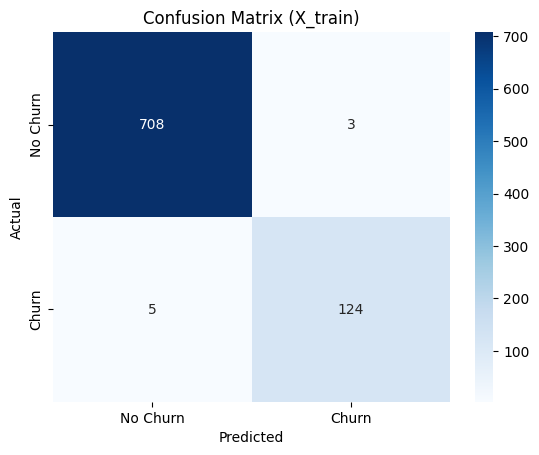

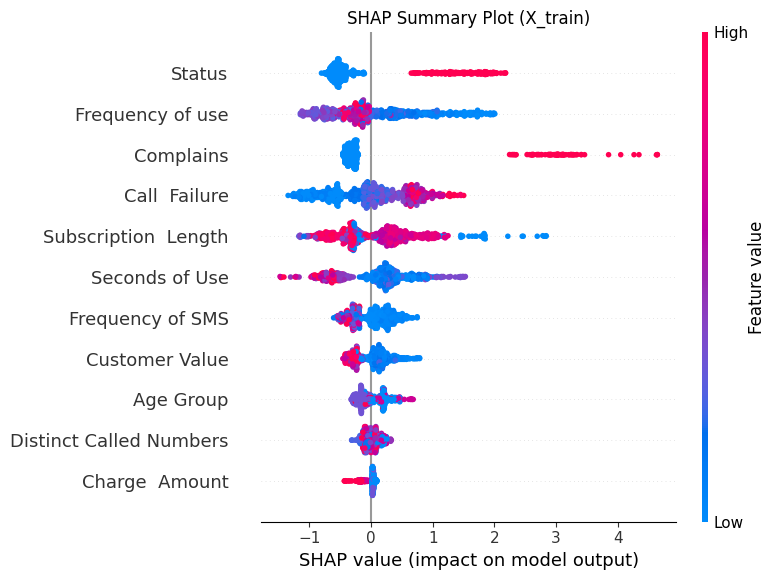

/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/07/12 00:52:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/s

🏃 View run calm-wasp-402 at: http://18.224.82.30:5000/#/experiments/1/runs/b2e9c1f081fb40788ce18c892c78d435
🧪 View experiment at: http://18.224.82.30:5000/#/experiments/1


In [ ]:
# First evaluate tuned model on training data to check for bias
evaluate_model(clf, X_train, y_train, "X_train")

Training model with the following features:
- Feature 0: Call  Failure
- Feature 1: Complains
- Feature 2: Subscription  Length
- Feature 3: Charge  Amount
- Feature 4: Seconds of Use
- Feature 5: Frequency of use
- Feature 6: Frequency of SMS
- Feature 7: Distinct Called Numbers
- Feature 8: Age Group
- Feature 9: Status
- Feature 10: Customer Value

Metrics for X_test:
log_loss: 0.1812
f1_score: 0.8354
precision_score: 0.8919
recall_score: 0.7857
accuracy_score: 0.9381

Classification Report (X_test):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       168
           1       0.89      0.79      0.84        42

    accuracy                           0.94       210
   macro avg       0.92      0.88      0.90       210
weighted avg       0.94      0.94      0.94       210



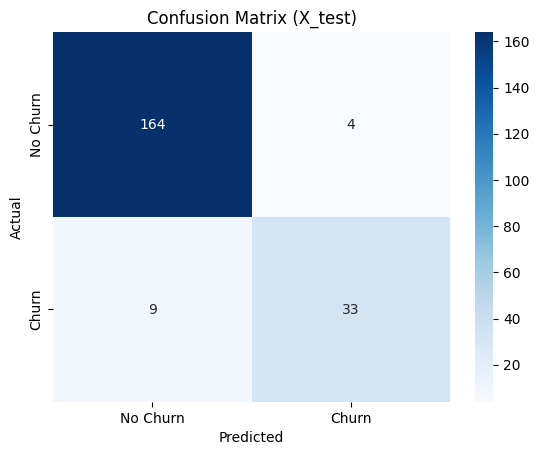

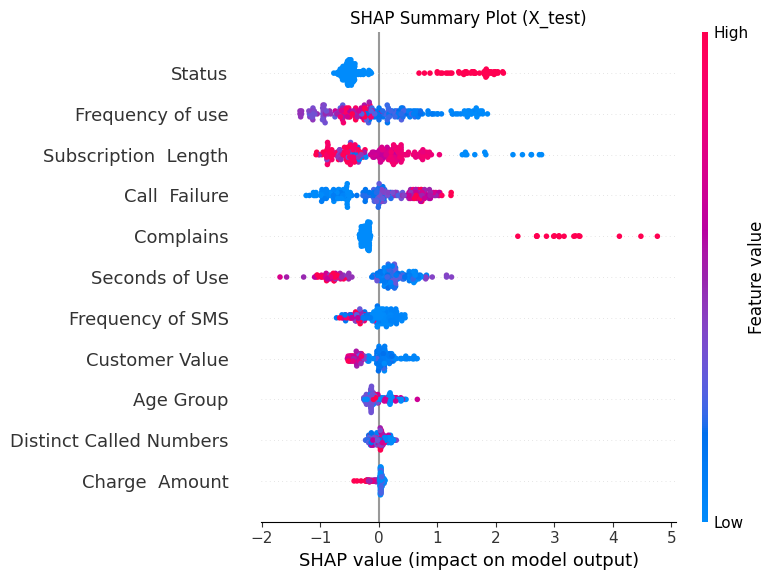

/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/07/12 00:53:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/pt7481/.local/share/virtualenvs/mlops-churn-pipeline-hToibVsu/lib/python3.12/s

🏃 View run chill-stork-858 at: http://18.224.82.30:5000/#/experiments/1/runs/5c9ecba407e84dd188baf7369ee454e5
🧪 View experiment at: http://18.224.82.30:5000/#/experiments/1


In [ ]:
# Next evaluate tuned model on test data to check for variance
evaluate_model(clf, X_test, y_test, "X_test")